In [2]:
from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random

In [4]:
#Auth parameters
my_token = "yaKfFeAsha8tNAZxvYeZBMmq-khO8tz-6Ut_PARgohiWzeW2j8BB86ND33Qbq7hR8bylmOROPQAUr-7M103_Yw=="
my_org = "iot-org"
bucket = "iot-demo"
client = InfluxDBClient(url="http://192.168.1.100:9999", token=my_token, org=my_org, debug=False)

In [5]:
days = '10d'
n_days = 10

queryTemperature = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "temperature")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days

queryHumidity = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "humidity")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days

queryPressure = '''
from(bucket: "iot-demo")
  |> range(start: -%s, stop: now())
  |> filter(fn: (r) => r["_measurement"] == "pressure")
  |> filter(fn: (r) => r["device"] == "RoomWeather")
  |> aggregateWindow(every: 5m, fn: median)
  ''' % days



In [4]:
#Query InfluxDB and return a Dataframe
#dfTemp = client.query_api().query_data_frame(org=my_org, query=queryTemperature)
#dfHum = client.query_api().query_data_frame(org=my_org, query=queryHumidity)
#dfPress = client.query_api().query_data_frame(org=my_org, query=queryPressure)

df = pd.read_csv("dataframe.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
df = df.asfreq(freq='300S')
points_per_day = 288 
df.head()

,temperature,humidity,pressure,people
time,,,,
2020-07-07 12:10:00+00:00,29.25,46.9,1019.5,0.0
2020-07-07 12:15:00+00:00,29.40,46.8,1019.5,0.0
2020-07-07 12:20:00+00:00,29.40,46.8,1019.5,0.0
2020-07-07 12:25:00+00:00,29.40,46.5,1019.5,0.0
2020-07-07 12:30:00+00:00,29.40,46.5,1019.5,0.0


In [5]:
df = pd.DataFrame(dfTemp['_time']).rename(columns={'_time':'time'})
df['temperature'] = dfTemp['_value']
df['humidity'] = dfHum['_value']
df['pressure'] = dfPress['_value']
df = df.set_index('time')
df = df.asfreq(freq='300S')
df.head()

NameError: name 'dfTemp' is not defined

In [7]:
print(df['temperature'].isnull().sum())
print(df['humidity'].isnull().sum())
print(df['pressure'].isnull().sum())

0
0
0


In [8]:
df['temperature'] = df['temperature'].fillna(method='backfill').fillna(method='ffill')
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')
df['pressure'] = df['pressure'].fillna(method='backfill').fillna(method='ffill')

In [10]:
#points_per_day = int(len(df)/n_days) 
#points_per_day

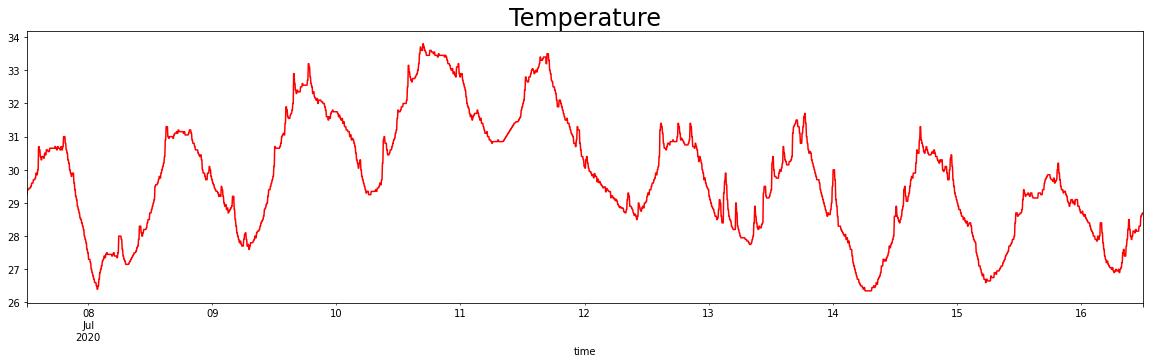

In [11]:
df.temperature.plot(figsize = (20,5), color = "red")
plt.title("Temperature", size = 24)
plt.show()                          

In [50]:
size = len(df)-points_per_day
df_train, df_test = df.iloc[:size], df.iloc[size:]

end_pred = points_per_day - 1

start_date = df_test.index[0]
end_date = df_test.index[end_pred]

# Temperature

In [51]:
# fit model
model = ExponentialSmoothing(df_train.temperature, seasonal="add",seasonal_periods = 288)#trend = "add")#, seasonal = "mul", seasonal_periods=500)
model_fit = model.fit()#optimized=True)#, use_boxcox=True, remove_bias=True)

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2303
Model:             ExponentialSmoothing   SSE                             29.562
Optimized:                         True   AIC                          -9450.698
Trend:                             None   BIC                          -7785.527
Seasonal:                      Additive   AICC                         -9365.568
Seasonal Periods:                   288   Date:                 Sat, 18 Jul 2020
Box-Cox:                          False   Time:                         01:43:23
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8947368                alpha                 True
smoothing_seasonal    

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


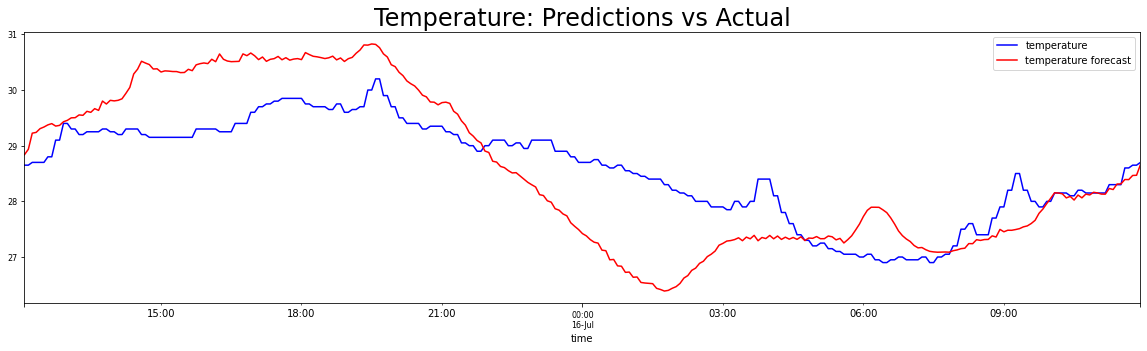

ABSOLUTE ERROR 0.7048533416309695
MSE 0.7475410141175809


In [52]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.temperature[:end_pred].plot(figsize = (20,5),color = "blue", legend = True)
df_forecast.plot(color = "red", legend = True, label = "temperature forecast")
plt.title("Temperature: Predictions vs Actual", size = 24)
plt.tick_params(labelsize=8)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.temperature[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.temperature[:end_pred], df_forecast)))

# Humidity

In [53]:
# fit model
model = ExponentialSmoothing(df_train.humidity, seasonal="add",seasonal_periods = 288)#trend="add")# seasonal="mul",seasonal_periods = 288)
model_fit = model.fit()

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2303
Model:             ExponentialSmoothing   SSE                            214.997
Optimized:                         True   AIC                          -4881.206
Trend:                             None   BIC                          -3216.035
Seasonal:                      Additive   AICC                         -4796.075
Seasonal Periods:                   288   Date:                 Sat, 18 Jul 2020
Box-Cox:                          False   Time:                         01:43:57
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8421053                alpha                 True
smoothing_seasonal    

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


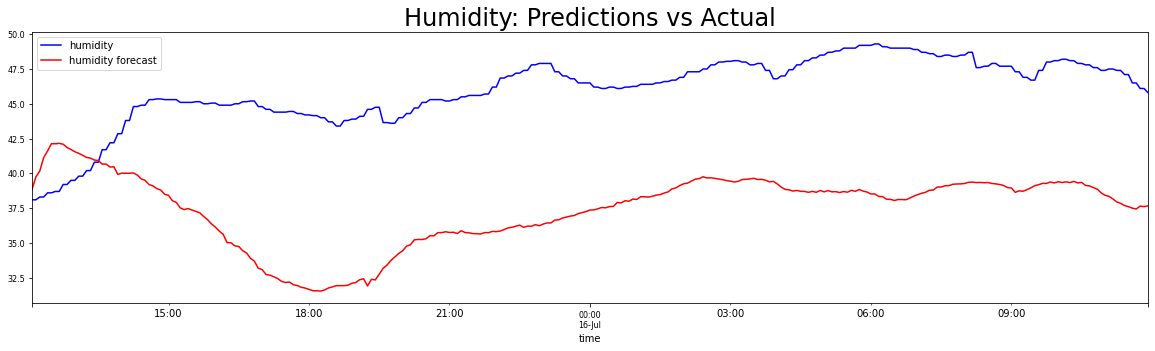

ABSOLUTE ERROR 8.79386994072302
MSE 84.05166958920634


In [54]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[:end_pred].plot(figsize = (20,5),color = "blue", legend = True)
df_forecast.plot(color = "red", legend = True, label = "humidity forecast")
plt.title("Humidity: Predictions vs Actual", size = 24)
plt.tick_params(labelsize=8)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.humidity[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.humidity[:end_pred], df_forecast)))

# Pressure

In [59]:
# fit model
model = ExponentialSmoothing(df_train.pressure, seasonal="add",seasonal_periods = 288) #seasonal = "mul", seasonal_periods=288)
model_fit = model.fit()

print(model_fit.summary())

df_forecast = model_fit.forecast(end_pred)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2303
Model:             ExponentialSmoothing   SSE                             62.003
Optimized:                         True   AIC                          -7744.851
Trend:                             None   BIC                          -6079.680
Seasonal:                      Additive   AICC                         -7659.721
Seasonal Periods:                   288   Date:                 Sat, 18 Jul 2020
Box-Cox:                          False   Time:                         01:44:56
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8947368                alpha                 True
smoothing_seasonal    

/home/laura/anaconda3/envs/jupyterEnv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


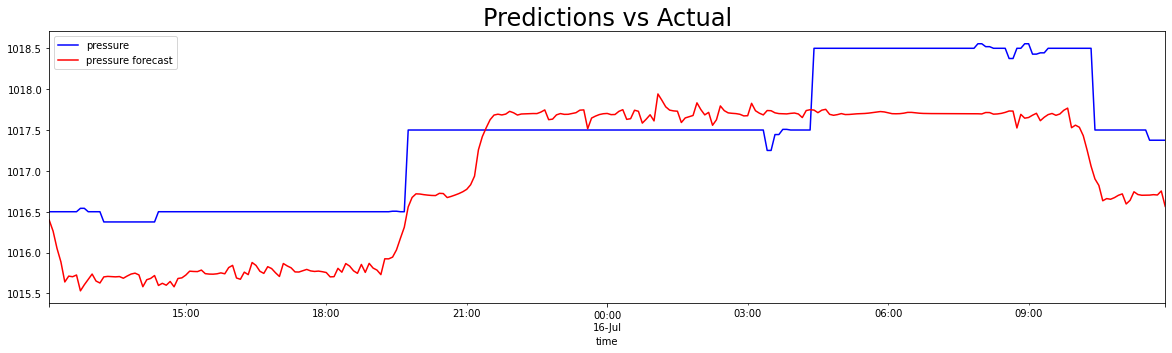

ABSOLUTE ERROR 0.5938124042617515
MSE 0.4312328334157907


In [60]:
#df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.pressure[:end_pred].plot(figsize = (20,5),color = "blue", legend = True)
df_forecast.plot(color = "red", legend = True, label = "pressure forecast")
plt.title("Predictions vs Actual", size = 24)
plt.show()                          

print("ABSOLUTE ERROR "+str(mean_absolute_error(df_test.pressure[:end_pred], df_forecast)))
print("MSE "+str(mean_squared_error(df_test.pressure[:end_pred], df_forecast)))